<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Working with Satellite Data</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>


## Overview:

* **Teaching:** 60 minutes
* **Exercises:** 30 minutes

### Questions
1. How can satellite data be obtained with Siphon?
2. What format is satellite data distributed in?
3. How can MetPy be used to open and explore satellite data?
4. How can maps of satellite data be made?
5. How can other datasets be integrated with satellite data?

### Objectives
1. Download satellite data with Siphon
2. Parse out netCDF file
3. Make a plot of the data
4. Use colortables and annotations
5. Bonus: Animations

## 1. Download satellite data with Siphon

The first step is to find the satellite data. Normally, we would browse over to http://thredds.ucar.edu/thredds/ and find the top-level [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) catalog. From there we can drill down to find satellite data products.

For this tutorial, we want to utilize the new GOES-16 imagery. This imagery is still considered experimental and not for operational use, so it is found on the test dataserver at http://thredds-test.unidata.ucar.edu/. Navigate to the `Test Datasets` directory, then `GOES-16 Products` and `GOES-16`. There are subfolders for the CONUS, full disk, and mesoscale sector images. In each of theses is a folder for each [channel of the ABI](http://www.goes-r.gov/education/ABI-bands-quick-info.html). In each channel there is a folder for every day in the month-long rolling archive. As you can see, there is a massive amount of data coming down from GOES-16!

We could download the files to our computers from here, but that can become tedious for downloading many files, requires us to store them on our computer, and does not lend itself to automation.

We can use Unidata's [Siphon](https://github.com/Unidata/siphon) package to parse the catalog from the TDS. This provides us a nice programmatic way of accessing the data. We start by importing the `TDSCatalog` class from siphon and giving it the URL to the catalog we just surfed to manually. **Note:** Instead of giving it the link to the HTML catalog, we change the extension to XML, which asks the TDS for the XML version of the catalog. This is much better to work with in code. 

Next we'll build a URL to get to the current day's data for a specified channel and region:

In [1]:
from datetime import datetime
from siphon.catalog import TDSCatalog

date = datetime.utcnow()
channel = 8
region = 'Mesoscale-2'

cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/'
                 '{}/Channel{:02d}/{:%Y%m%d}/catalog.xml'.format(region, channel, date))

We now have a `TDSCatalog` object called `cat` that we can examine and use to get handles to work with the data. To find the latest file, we can look at the `cat.datasets` attribute. This is a Python dictionary, mapping the name of the dataset to a Python Dataset object (which came from more XML supplied by the TDS). Since this is a dictionary, we can look at a list of keys and see what datasets are available. Let’s look at the last five keys:

In [2]:
list(cat.datasets)[-5:]

['GOES16_Mesoscale-2_20170928_213757_6.19_2km_37.7N_68.2W.nc4',
 'GOES16_Mesoscale-2_20170928_213857_6.19_2km_37.7N_68.2W.nc4',
 'GOES16_Mesoscale-2_20170928_213957_6.19_2km_37.7N_68.2W.nc4',
 'GOES16_Mesoscale-2_20170928_214057_6.19_2km_37.7N_68.2W.nc4',
 'GOES16_Mesoscale-2_20170928_214157_6.19_2km_37.7N_68.2W.nc4']

We'll get the next to most recent dataset (sometimes the most recent will not have received all tiles yet) using the OPENDAP protocol.

In [3]:
ds = cat.datasets[-2]
ds = ds.remote_access(service='OPENDAP')

### Exercise: Find your own data

<hr style="height:2px;">

## 2. Parse out the netCDF File

We have a [netCDF4-python](https://unidata.github.io/netcdf4-python/) dataset object now that contains all of the data for a given satellite image. We need to explore the variables available in the file and pull out the useful parts that we need to make a map.

In [4]:
list(ds.variables)

['time', 'y', 'x', 'lambert_projection', 'Sectorized_CMI']

Our goal is to plot the imagery, so we'll be using the `Sectorized_CMI` variable from the `.variables` dictionary.
Rather than just giving back the raw array of data, this gives back a `Variable` object; from here not only
can we get the raw data values, but there is useful metadata as well. We can see just what additional information
is present by printing out the `Variable` object:

In [5]:
data_var = ds.variables['Sectorized_CMI']
print(data_var)

<class 'netCDF4._netCDF4.Variable'>
int16 Sectorized_CMI(y, x)
    _FillValue: 0
    standard_name: brightness_temperature
    units: kelvin
    grid_mapping: lambert_projection
    add_offset: 138.05
    scale_factor: 0.0422499
    valid_min: 0
    valid_max: 4095
    coordinates: time y x
    _ChunkSizes: [675 682]
unlimited dimensions: 
current shape = (675, 682)
filling off



This reveals several useful pieces of information (such as a longer description of the variable), but we're going to focus on the `grid_mapping` data. This attribute is defined by the [NetCDF Climate and Forecast (CF) Metadata Conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html) and specifies a variable that contains information about the grid's projection.

We also need to get the x and y coordinates of the image from the dataset object. We use an empty slice (`[:]`) to copy the actual numeric values out of the variables (for easier use with matplotlib and cartopy).

In [6]:
x = ds.variables['x'][:]
y = ds.variables['y'][:]

We will also grab the variable corresponding to the `grid_mapping` attribute so that we can have a look at the projection information. Rather than hard coding the name of the variable (in this case `Lambert_Conformal`), we just directly pass the `grid_mapping` attribute to the `.variables` dictionary; this makes it easier to re-use the code in the future with different data.

In [7]:
proj_var = ds.variables[data_var.grid_mapping]
print(proj_var)

<class 'netCDF4._netCDF4.Variable'>
int32 lambert_projection()
    grid_mapping_name: lambert_conformal_conic
    standard_parallel: 36.8197962398
    longitude_of_central_meridian: -69.0078943432
    latitude_of_projection_origin: 36.8197962398
    false_easting: 0.0
    false_northing: 0.0
    semi_major: 6371200.0
    semi_major_axis: 6371200.0
    semi_minor: 6371200.0
    semi_minor_axis: 6371200.0
unlimited dimensions: 
current shape = ()
filling off



This shows that the projection is [Lambert conformal conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) generally, but sometimes is [Mercator](https://en.wikipedia.org/wiki/Mercator_projection) (remember these data are still experimental). The variable also includes a few parameters (such as the latitude and longitude of the origin) needed to properly set up the projection to match what was used to create the image. This variable also has information about the assumed shape of the earth, which in this case is spherical with a radius of 6371.2 km.

### Exercise: Parse your data

<hr style="height:2px;">

## 3. Make a plot of the data

We are finally ready to plot the satellite data! Using `imshow()` we can get an image, but there is a lot of work to do here. The data need to be projected to a meaningful representation, map outlines added, and annotations added.

In [8]:
# Make sure the notebook puts figures inline
%matplotlib inline
import matplotlib.pyplot as plt

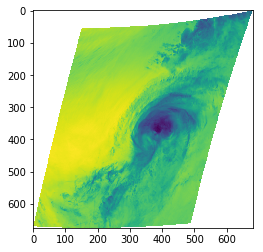

In [9]:
plt.imshow(data_var[:])

### Projections

The mapping will be accomplished with a combination of Cartopy and Matplotlib. To begin, we will use Cartopy’s `crs` (Coordinate Reference System) module. With the `crs`, we will create a `Globe` object that contains information about the assumed planet shape used in the projection.

In [10]:
proj_var

<class 'netCDF4._netCDF4.Variable'>
int32 lambert_projection()
    grid_mapping_name: lambert_conformal_conic
    standard_parallel: 36.8197962398
    longitude_of_central_meridian: -69.0078943432
    latitude_of_projection_origin: 36.8197962398
    false_easting: 0.0
    false_northing: 0.0
    semi_major: 6371200.0
    semi_major_axis: 6371200.0
    semi_minor: 6371200.0
    semi_minor_axis: 6371200.0
unlimited dimensions: 
current shape = ()
filling off

In [11]:
import cartopy.crs as ccrs

# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major,
                   semiminor_axis=proj_var.semi_minor)

Now that we have a globe of the appropriate shape, we need to create our projection. Knowing that the data are using the Lambert conformal conic or Mercator projections, we will use the `LambertConformal` or `Mercator` classes. These classes use the globe model we just created, along with the projection information from the file metadata.

In [12]:
# Select the correct projection.

if proj_var.grid_mapping_name == 'lambert_conformal_conic':
    proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                                 central_latitude=proj_var.latitude_of_projection_origin,
                                 standard_parallels=[proj_var.standard_parallel],
                                 globe=globe)

else:
    proj = ccrs.Mercator(central_longitude=proj_var.longitude_of_projection_origin, 
                         latitude_true_scale=proj_var.standard_parallel,
                         globe=globe)

### Plotting

Now that we know how to properly reference the imagery data, we can plot
the data. CartoPy's projections are designed to interface with matplotlib, so they can just be passed as the `projection` keyword argument when creating an `Axes` using the `add_subplot` method. Since the x and y coordinates, as well as the image data, are referenced in the lambert conformal projection, we can pass all of them directly to plotting methods (such as `imshow`) with no additional information. The `extent` keyword argument to `imshow` is used to specify the bounds of the image data being plotted. It is **especially important** to specify that the `origin` is at the the upper left of the image (standard practice in imagery). If your forget this, your image will be flipped. Try it!

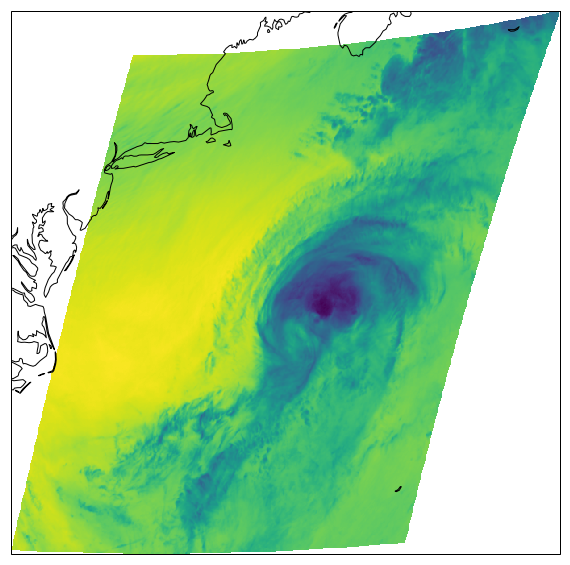

In [13]:
# Create a new figure with size 10" by 10"
fig = plt.figure(figsize=(10, 10))

# Put a single axes on this figure; set the projection for the axes to be our
# Lambert conformal projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the data with mostly the defaults
# Note, we save the image returned by imshow for later...
im = ax.imshow(data_var[:], extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

# Add high-resolution coastlines to the plot
ax.coastlines(resolution='50m', color='black')

This is a nice start, but it would be nice to have better geographic references for the image. For example, where are the states? Cartopy's `feature` module has support for adding geographic features to plots ,with many features are built in. The `BORDERS` built-in feature contains country borders. There is also support for creating "custom" features from the [Natural Earth](http://www.naturalearthdata.com/) set of free vector and raster map data (CartoPy will automatically download the necessary data and cache it locally). Here we create a feature for states/provinces.

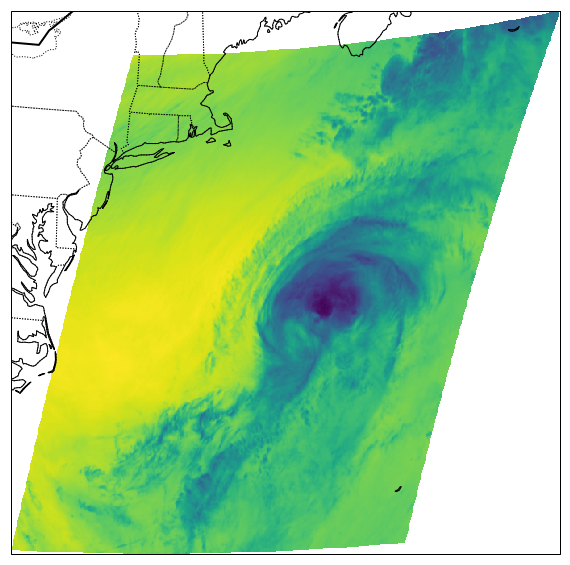

In [14]:
import cartopy.feature as cfeat

# Add country borders with a thick line.
ax.add_feature(cfeat.BORDERS, linewidth=2, edgecolor='black')

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

# Add the feature with dotted lines, denoted by ':'
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')

# Redisplay modified figure
fig

### Exercise: Plot your data

<hr style="height:2px;">

## 4. Use colortables and annotations

The map is much improved now, but it would look much better with a different color scheme. 

Colormapping in matplotlib (which backs CartoPy) is handled through two pieces:

- The colormap controls how values are converted from floating point values in the range [0, 1] to colors (think colortable)
- The norm (normalization) controls how data values are converted to floating point values in the range [0, 1]

Let's start by setting the colormap to be black and white and normalizing the data to get the best contrast. We'll make a histogram to see the distribution of values in the data, then clip that range down to enhance contrast in the data visualization.  **Note:** `cmap` and `norm` can also be set during the `imshow` call as keyword arguments.

We `flatten` the 2D array down to 1D for the histogram and remove any masked elements with `compressed`.

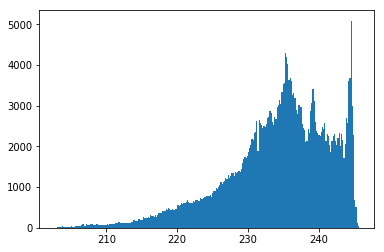

In [15]:
plt.hist(data_var[:].compressed().flatten(), bins=255);

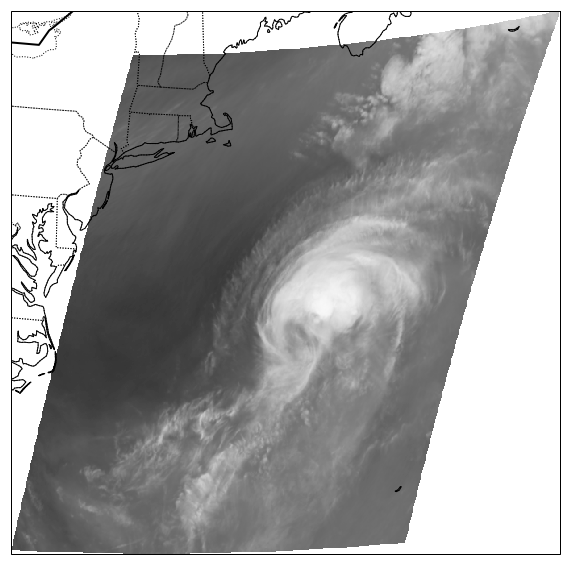

In [16]:
# Set colormap
im.set_cmap('Greys')

# Set norm
im.set_norm(plt.Normalize(200,255))

# Show figure again
fig

In meteorology, we have many ‘standard’ colortables that have been used for certain types of data. We have included these in Metpy in the `metpy.plots.ctables` module. By importing the `ColortableRegistry` we gain access to the colortables, as well as handy normalizations to go with them. We can see the colortables available by looking at the dictionary keys. The colortables ending in `_r` are the reversed versions of the named colortable.

In [17]:
from metpy.plots.ctables import registry

print(registry.keys())

dict_keys(['NWSVelocity', 'NWSVelocity_r', 'ir_tv1', 'ir_tv1_r', 'NWSSpectrumWidth', 'NWSSpectrumWidth_r', 'WVCIMSS', 'WVCIMSS_r', 'NWS8bitVel', 'NWS8bitVel_r', 'Carbone42', 'Carbone42_r', 'ir_tpc', 'ir_tpc_r', 'NWSStormClearReflectivity', 'NWSStormClearReflectivity_r', 'NWSReflectivity', 'NWSReflectivity_r', 'ir_drgb', 'ir_drgb_r', 'wv_tpc', 'wv_tpc_r', 'test', 'test_r', 'NWSReflectivityExpanded', 'NWSReflectivityExpanded_r', 'rainbow', 'rainbow_r', 'viridis', 'viridis_r', 'ir_bd', 'ir_bd_r', 'ir_rgbv', 'ir_rgbv_r'])


Let’s use the `WVCIMSS` colormap, a direct conversion of the GEMPAK colormap. The code below asks for the colormap, as well as a normalization that starts at 0 and increases by a value of 1 for each color in the table. We then apply it to the existing image we have been working with.

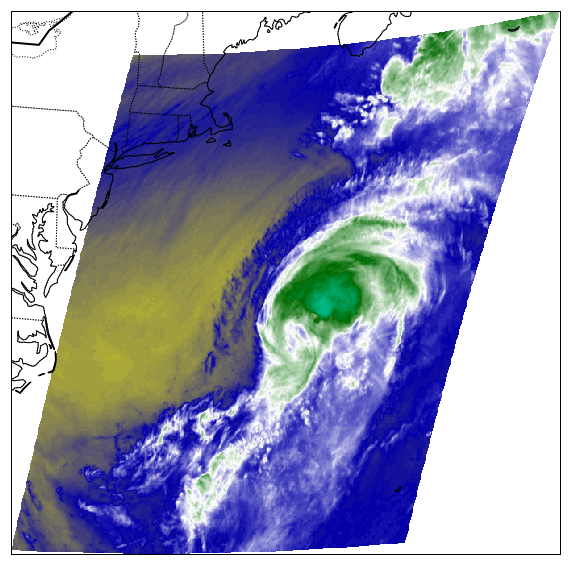

In [18]:
wv_norm, wv_cmap = registry.get_with_range('WVCIMSS_r', 195, 265)
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
fig

One more thing that would be nice is putting the date and time on the image, so let's do that. First grab the `start_date_time` attribute from the dataset object:

In [19]:
ds.start_date_time

'2017271214057'

This timestamp contains the year, Julian day, hour, minute, and second that the image was collected. We will use `datetime.strptime` to parse this out into a Python `datetime` object.

In [20]:
timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
print(timestamp)

2017-09-28 21:40:57


A Python `datetime` object is easy to work with. Let's add it to our plot.

We use the `text` method to draw text on our plot. In this case, we call it with a `transform` keyword argument, which allows us to tell matplotlib how to interpret the x and y coordinates. In this case, we set the transform to `ax.transAxes`, which means "interpret x and y as being in axes space". The axes space has x and y in the range [0, 1] across the entire plotting area (e.g. (0, 0) is lower left, (1, 1) is upper right). Using this, we can put text in the lower right corner (`x = 0.99`, `y = 0.01`) regardless of the range of x and y (or longitude and latitude) in the plot. We also need to make sure to right-align the text so that the text *ends* at the specified point.

We use the `strftime` method to format the datetime as a string. The details of that format string are described [here](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior).

We also need to add an annotation telling us what channel is being plotted, as well as a statement that the data are experimental.

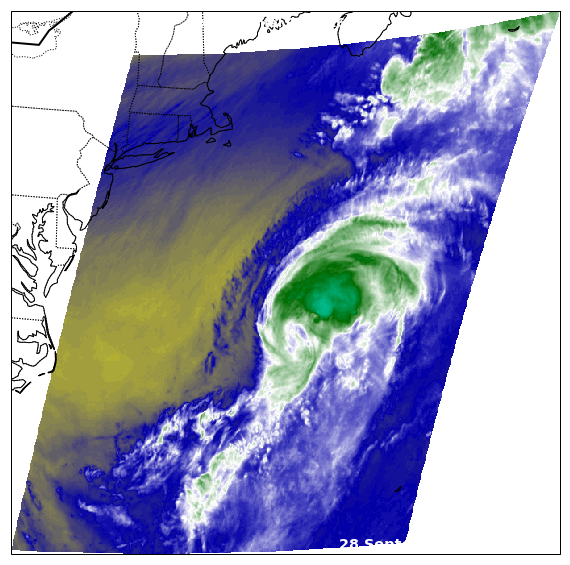

In [21]:
# Add text (aligned to the right); save the returned object so we can manipulate it.
text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

text_channel = ax.text(0.5, 0.97, 'Experimental GOES-16 Ch.{}'.format(channel),
               horizontalalignment='center', transform=ax.transAxes,
               color='white', fontsize='large', weight='bold')
fig

Well, that's a good idea, but the text is invisible in some places! White text and black text have issues, but we can outline the text using matplotlib's [path effects](http://matplotlib.org/users/patheffects_guide.html). More details on path effects can be found in the [documentation](http://matplotlib.org/users/patheffects_guide.html) if you want to know more.



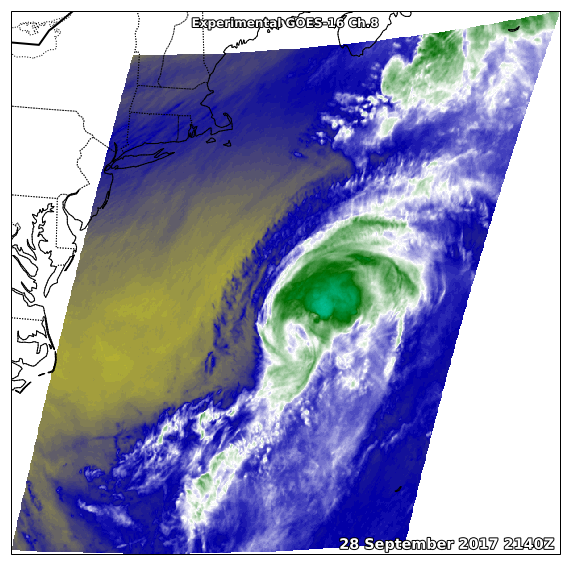

In [22]:
# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)
fig

In [23]:
# Add the MetPy or Unidata Logo
from metpy.plots import add_metpy_logo, add_unidata_logo
fig = add_metpy_logo(fig)
fig

## All Together Now!
Here's the complete plot in one cell for easy reference:

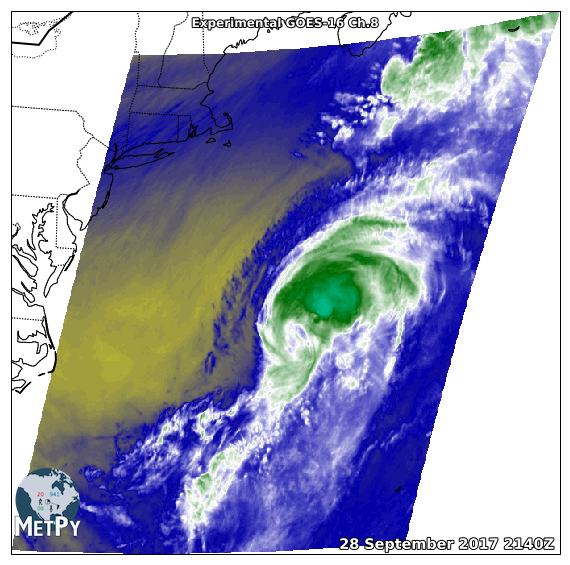

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(data_var[:], extent=(x.min(), x.max(), y.min(), y.max()), origin='upper',
               cmap=wv_cmap, norm=wv_norm)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth=2, edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

text_channel = ax.text(0.5, 0.97, 'Experimental GOES-16 Ch.{}'.format(channel),
               horizontalalignment='center', transform=ax.transAxes,
               color='white', fontsize='large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)

fig = add_metpy_logo(fig)

### Exercise: Enhance your plot

<hr style="height:2px;">

## Bonus: Animations

**NOTE:**
This is just a quick taste of producing an animation using matplotlib. The animation support in matplotlib is robust, but sometimes installation of the underlying tools (mencoder/ffmpeg) can be a little tricky. In order to make sure we get don't get bogged down, this is really more of a demo than something expected to work out of the box.

For windows builds, you might try:
- For [ffmpeg](https://ffmpeg.zeranoe.com/builds/)
- For [mencoder](https://www.mplayerhq.hu/design7/dload.html)

On OSX and linux, conda-forge has packages, so it may be as easy as:

In [25]:
#!conda install -y -n unidata-workshop -c http://conda.anaconda.org/conda-forge ffmpeg

First we'll import the animation support from matplotlib. We also tell it that we want it to render the animations to HTML using the HTML5 video tag:

In [26]:
import os.path
import sys
from matplotlib import rcParams
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

Then we create an empty figure which will serve as the basis for all of the frames of the animation:

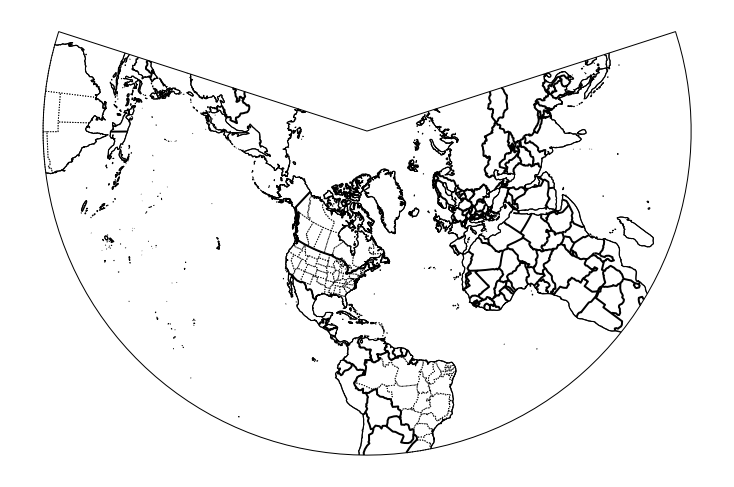

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=proj)
plt.subplots_adjust(left=0.005, bottom=0.005, right=0.995, top=0.995, wspace=0, hspace=0)
ax.coastlines(zorder=2)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth=2, edgecolor='black')

Then we loop over a bunch of the datasets. For each one we pull out the data and plot both the timestamp and the image. The `ArtistAnimation` class takes the `Figure` instance and a list as required arguments. The contents of this list is a collection of matplotlib artists for each frame of the animation. In the loop below, we populate this list with the `Text` instance created when adding the timestamp as well as the image that results from plotting the data.

In [28]:
# Add the MetPy Logo
add_metpy_logo(fig)

# List used to store the contents of all frames. Each item in the list is a tuple of
# (image, text)
artists = []

# Loop over the last 60 satellite images in the catalog
for ds in cat.datasets[-60:]:

    # Open the data using the HTTPServer access url and pass to GINIFile. Then convert
    # it to a netcdf-like dataset
    nc = ds.remote_access(service='OPENDAP')

    # Pull out the image data, x and y coordinates, and the time. Also go ahead and
    # convert the time to a python datetime
    x = nc.variables['x'][:]
    y = nc.variables['y'][:]
    timestamp = datetime.strptime(nc.start_date_time, '%Y%j%H%M%S')
    img_data = nc.variables['Sectorized_CMI'][:]

    # Plot the image and the timestamp. We save the results of these plotting functions
    # so that we can tell the animation that these two things should be drawn as one
    # frame in the animation
    im = ax.imshow(img_data, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper',
                   cmap=wv_cmap, norm=wv_norm)

    # Add text (aligned to the right); save the returned object so we can manipulate it.
    text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
                   horizontalalignment='right', transform=ax.transAxes,
                   color='white', fontsize='x-large', weight='bold', animated=True)

    text_channel = ax.text(0.5, 0.97, 'Experimental GOES-16 Ch.{}'.format(channel),
                   horizontalalignment='center', transform=ax.transAxes,
                   color='white', fontsize='large', weight='bold', animated=True)

    # Make the text stand out even better using matplotlib's path effects
    outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
    text_time.set_path_effects(outline_effect)
    text_channel.set_path_effects(outline_effect)
    
    # Stuff them in a tuple and add to the list of things to animate
    artists.append((im, text_time, text_channel))

# Create the animation--in addition to the required args, we also state that each
# frame should last 200 milliseconds
anim = ArtistAnimation(fig, artists, interval=200., blit=False)
anim.save('GOES_Animation.mp4')
HTML(anim.to_html5_video())